# Two-temperature model

This Julia code solves the two-temperature model for the electron and lattice subsystems.

In [1]:
using Plots, LaTeXStrings, QuadGK, Unitful, DataFrames, DifferentialEquations

In [2]:
function electric_field(t, E0, f)
    return E0 * sin(2 * π * f * t) * exp(-t / 5.0u"ps") * (t >= 0u"s") * (1 - exp(-t / 1.0u"ps"))
end

Q_rh = 7.9e21u"Pa/s" |> u"Pa/ps"
U_rh = Q_rh * 5u"ps"

3.95e10 Pa

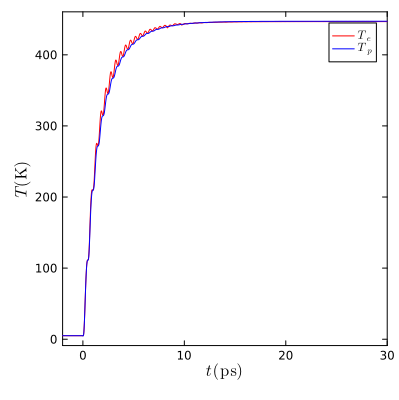

In [3]:
G = 1e18u"W/K/m^3" |> u"Pa/ps/K"
a_e = 100u"Pa/K^2"
σ = 5e3u"S/m"

function electric_field(t, E0, f)
    return E0 * sin(2 * π * f * t) * exp(-t / 5.0) * (t >= 0) * (1 - exp(-t / 1.0))
end

conductance = σ * (21u"nm" * 6u"μm" / 600u"nm") |> u"S"

function twotemp!(dT, T, p, t)
    G, σ = p[1], p[2]
    C_e = p[3] * T[1]
    C_l = p[4] * T[2]^3
    V = 600e-9 * electric_field(t, 2e8, 1.025)
    dT[1] = (1 / C_e) * (σ * V^2 - G * (T[1] - T[2]))
    dT[2] = (1 / C_l) * (G * (T[1] - T[2]))
end

T0 = [5.0; 5.0] # [K]
tspan = (-2.0, 30.0) # [ps]

kB = 1.38e-23u"J/K"
T_D = 420u"K"
n = 1e20u"cm^-3" |> u"m^-3"
a_l = (12 * π^4 * n * kB / 5) * (1 / T_D)^3 |> u"Pa/K^4"

prob = ODEProblem(twotemp!, T0, tspan, ustrip.([G, σ, a_e, a_l]))
sol = solve(prob,
    alg=AitkenNeville(),
    tstops=range(-1.0, 2.0, 20),
    save_everystep=true,
    maxiters=1e7);

plot(sol, color="red", label=L"$T_e$", xlabel=L"$t\,(\mathrm{ps})$", layout=(1, 1), idxs=1)
plot!(sol, color="blue", label=L"$T_p$", subplot=1, idxs=2)
plot!(framestyle=:box, size=(400, 400), xlabel=L"$t\,(\mathrm{ps})$", ylabel=L"$T\,(\mathrm{K})$", legend=:topright, grid=:off)

$$
    U = \int_{-\infty}^{\infty} \sigma E(t)^2\,\mathrm{d}t
$$

In [4]:
σ = 5e3u"S/m"
C_l = 4e6u"Pa/K"

function electric_field(t, E0, f)
    return E0 * sin(2 * π * f * t) * exp(-t / 3.0u"ps") * (t >= 0u"s") * (1 - exp(-t / 2.0u"ps"))
end

function dU(t)
    return σ * electric_field(t, 3u"MV/cm", 1.0u"THz")^2 / C_l |> u"K/s"
end

U = quadgk(dU, -5.0u"ps", 30.0u"ps")[1] |> u"K"

21.700254710236027 K

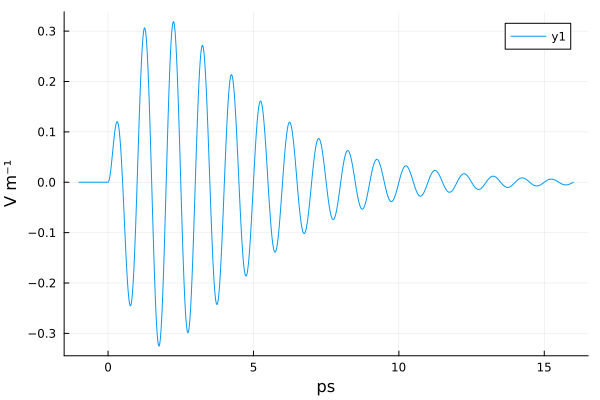

In [5]:
t = range(-1, 16, length=1000) .* 1u"ps"
plot(t, electric_field.(t, 1u"V/m", 1u"THz"))

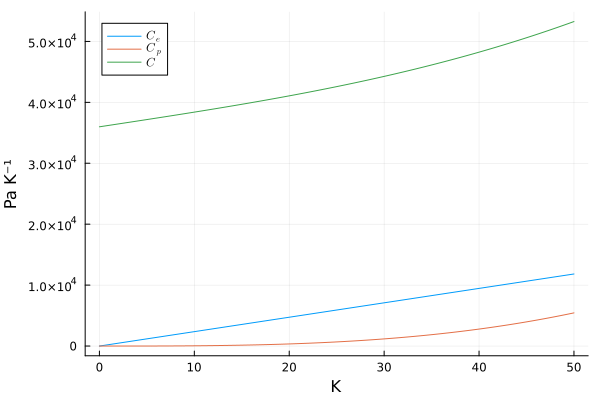

In [42]:

function lattice_heat_capacity(T)
    kB = 8.617333262145e-5u"eV/K"
    T_D = 420u"K"
    n = 1e21u"cm^-3"
    return (12 * π^4 * n * kB / 5) * (T / T_D)^3
end

function electron_heat_capacity(T)
    M = 250.932u"g/mol"
    ρ = 7.24u"g/cm^3"
    a = 8.2u"mJ/K^2/mol"
    a = a / M * ρ |> u"Pa/K^2"
    return a * T
end

function magnetic_heat_capacity(T)
    a = 0.15 * 8.3145u"J/K/mol" / 250.932u"g/mol" * 7.24u"g/cm^3" |> u"Pa/K"
end

function total_heat_capacity(T)
    return lattice_heat_capacity(T) + electron_heat_capacity(T) + magnetic_heat_capacity(T)
end

a = 80u"Pa/K^2"
T = range(0, 50, length=1000) .* 1u"K"
plot(T, electron_heat_capacity.(T), label=L"C_e")
plot!(T, lattice_heat_capacity.(T), label=L"C_p")
plot!(T, total_heat_capacity.(T), label=L"C")

In [44]:
volume = 3u"μm" * 0.3u"μm" * 12u"nm"

# Integrate from T = 10 to T = 50 K
Q = quadgk(total_heat_capacity, 5u"K", 200u"K")[1] * volume |> u"J"

3.150582636603671e-13 J